In [125]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from tqdm import tqdm, trange

from faceio import get_date_directories
from utils import attempt_load_day, load_day_to_batch
from network import create_network

# init device and ensure deterministic
SEED = 997
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda:0')

RATIO = 1
video_by_day = get_date_directories('bili_video', RATIO=RATIO)
model = create_network(device)
model.load_state_dict(torch.load('video2lip_ratio10_epoch100.pt'))

The model has 6,335,784 trainable parameters


<All keys matched successfully>

In [127]:
from math import sqrt

model.eval()
criterion = nn.MSELoss()
epoch_loss, epoch_slices = 0, 0

r = []

for day_idx in range(len(video_by_day)):

    source = video_by_day[day_idx]['sources'][day_idx][0]
    source = source[:source.rfind('/')]
    print('Evaluating on day %d (of %d): %s' % (day_idx+1, len(video_by_day), source))

    total_slices, src_lens, inputs, label = load_day_to_batch(video_by_day, day_idx, device)
    src_len = torch.Tensor(src_lens)

    output = model(inputs, src_len).view(-1, len(src_lens), 20, 2).cpu()
    r.append((source, src_len, label, output.detach()))

    loss = criterion(label, output)
    day_loss = loss.item() / total_slices
    epoch_loss += loss.item()
    epoch_slices += total_slices
    
    print('loss=%.5f / RMSE = %.5f' % (day_loss, sqrt(day_loss)))

overall_loss = epoch_loss/epoch_slices
print('overall loss for %d frames: %.5f / overall RMSE = %.5f' % (epoch_slices, overall_loss, sqrt(overall_loss)))

Evaluating on day 1 (of 6): /home/yunyangli/CMLR/bili_video/F/Woman2_F_Av970352315
loss=0.00004 / RMSE = 0.00671
Evaluating on day 2 (of 6): /home/yunyangli/CMLR/bili_video/F/WomenA_F_Av970352315
loss=0.00010 / RMSE = 0.01020
Evaluating on day 3 (of 6): /home/yunyangli/CMLR/bili_video/F/YangLi_F_Av330752427
loss=0.00005 / RMSE = 0.00722
Evaluating on day 4 (of 6): /home/yunyangli/CMLR/bili_video/M/LiDan_M_Av330752427
loss=0.00002 / RMSE = 0.00450
Evaluating on day 5 (of 6): /home/yunyangli/CMLR/bili_video/M/LuoXiang_M_Av330752427
loss=0.00001 / RMSE = 0.00278
Evaluating on day 6 (of 6): /home/yunyangli/CMLR/bili_video/M/ZhuYidan_M_Av330752427
loss=0.00008 / RMSE = 0.00870
overall loss for 5078 frames: 0.00003 / overall RMSE = 0.00563


In [72]:
r[0][1], r[0][2].shape

(tensor([179., 195., 243.]), torch.Size([243, 3, 20, 2]))

In [123]:
r_idx = 0
sel_r = r[r_idx]
source, src_len, label, output = sel_r

seq_idx = 0
seq_len = int(src_len[seq_idx].item())
seq_label = label[:seq_len, seq_idx, :, :]
seq_pred = output[:seq_len, seq_idx, :, :]

seq_label.shape, criterion(seq_label, seq_pred)

(torch.Size([52, 20, 2]), tensor(0.0036))

In [124]:
# ffmpeg -f image2 -i gen/lip%3d.jpg lip.mp4

for lip_idx in tqdm(range(seq_label.shape[0])):

    # %matplotlib inline
    import matplotlib.pyplot as plt
    fig = plt.figure(num=None, figsize=(12, 4), dpi=160, facecolor='w', edgecolor='k')
    fig.suptitle('SPEECH2LIP %s (seq %d, lip %d)' % (source, seq_idx, lip_idx), fontsize=16, y=1.03)
    plt.style.use('seaborn-whitegrid')

    def draw_lip(plt, lip):
        x,y = lip[:, 0], lip[:, 1]

        for i in range(12):
            x1,y1 = lip[i,0], lip[i,1]
            if i != 11:
                x2,y2 = lip[i+1,0], lip[i+1,1]
            else:
                x2,y2 = lip[0,0], lip[0,1]
            plt.plot([x1, x2], [y1, y2], color='#8D021F')

        for i in range(12, 20):
            x1,y1 = lip[i,0], lip[i,1]
            if i != 19:
                x2,y2 = lip[i+1,0], lip[i+1,1]
            else:
                x2,y2 = lip[12,0], lip[12,1]
            plt.plot([x1, x2], [y1, y2], color='#B80F0A')

        for i, z in enumerate(lip):
            plt.annotate(str(i+49), (z[0], z[1]))

        plt.plot(x, y, 'o', color='black')
        plt.set_xlim([-1.25, 1.25])
        plt.set_ylim([-0.75, 0.75])

    ax = plt.subplot(121)
    ax.set_title('Lip: groundtruth')
    draw_lip(ax, seq_label[lip_idx])
    ax = plt.subplot(122)
    ax.set_title('Lip: pred')
    draw_lip(ax, seq_pred[lip_idx])
    
    plt.savefig("gen2/lip%03d.jpg" % lip_idx)
    plt.close()

100%|██████████| 52/52 [00:12<00:00,  4.20it/s]


In [146]:
x = attempt_load_day(video_by_day, 4)

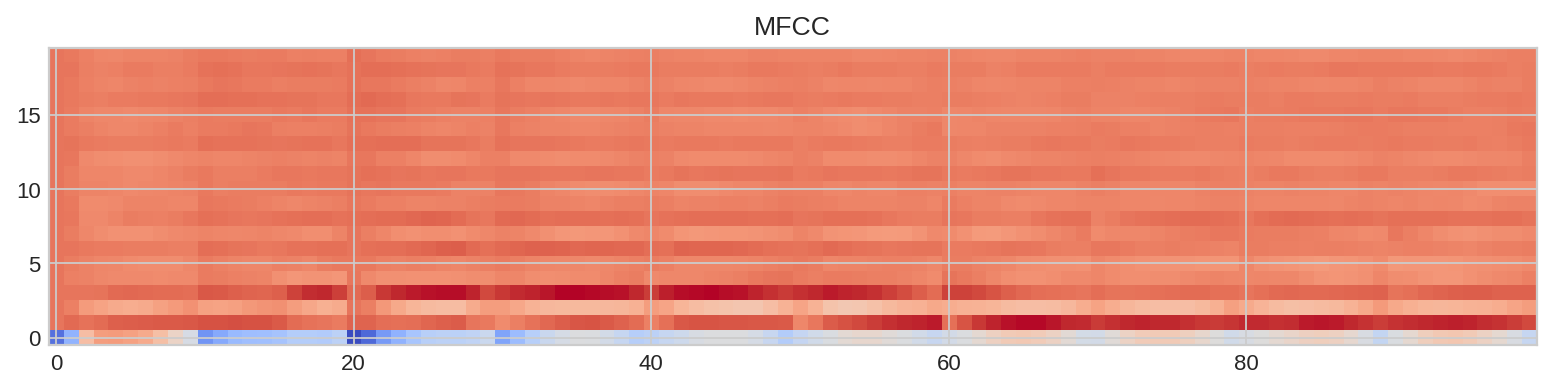

In [148]:
mfcc_data = x[0]['a'][:, :100]

from matplotlib import cm
%matplotlib inline
fig = plt.figure(num=None, figsize=(12, 4), dpi=160, facecolor='w', edgecolor='k')
ax = plt.subplot(111)
cax = ax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower')
ax.set_title('MFCC')

plt.show()